In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 0. Environment setup
!pip -q install xgboost shap lime scikit-learn pandas numpy matplotlib seaborn

import warnings, os, json
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

import shap
import lime
import lime.lime_tabular

np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
csv_path = "/content/drive/MyDrive/credit_risk_dataset.csv"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# 2. Quick data overview
print("Columns:", df.columns.tolist())
print("\nBasic info:")
print(df.info())
print("\nSample value counts for probable target columns:")
for col in df.columns:
    if df[col].dtype == 'object':
        vc = df[col].value_counts(dropna=False)
        if (vc.shape[0] <= 5) and (vc.shape[0] >= 2):
            print(f"\n{col}:\n{vc}")

Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loa

In [6]:
# 3. Target mapping
# Try common target column names; adjust if needed.
possible_targets = ["loan_status", "default", "is_default", "Default"]
target_candidates = [c for c in possible_targets if c in df.columns]
if len(target_candidates) == 0:
    raise ValueError("Target column not found. Set TARGET_COL to your target column name and define mapping below.")

TARGET_COL = target_candidates[0]
print("Using target column:", TARGET_COL)

# Default mapping for LendingClub-style loan_status
# Edit this mapping if your values differ (print value_counts to verify)
print(df[TARGET_COL].value_counts())
mapping = {
    "Charged Off": 1, "Default": 1, "Late (31-120 days)": 1, "In Default": 1,
    "Fully Paid": 0, "Current": 0, "Issued": 0, "Late (16-30 days)": 1
}
# If target is already numeric/binary, this step will be skipped gracefully
if df[TARGET_COL].dtype == 'object':
    df["target"] = df[TARGET_COL].map(mapping)
else:
    df["target"] = df[TARGET_COL]

# Drop rows with unmapped targets
df = df[df["target"].isin([0, 1])].copy()
print("Target distribution:\n", df["target"].value_counts(normalize=True))


Using target column: loan_status
loan_status
0    25473
1     7108
Name: count, dtype: int64
Target distribution:
 target
0    0.781836
1    0.218164
Name: proportion, dtype: float64


In [7]:
# 4. Basic cleaning: remove obvious ID-like columns and high-missing columns
# Customize this list based on df.columns
drop_like = [c for c in df.columns if c.lower() in ["id", "member_id", "url"]]
df = df.drop(columns=drop_like, errors="ignore")

# Remove columns with >90% missing
missing_ratio = df.isna().mean()
high_missing = missing_ratio[missing_ratio > 0.90].index.tolist()
df = df.drop(columns=high_missing, errors="ignore")

print("Dropped columns (ID/high-missing):", drop_like + high_missing)
print("Remaining columns:", len(df.columns))


Dropped columns (ID/high-missing): []
Remaining columns: 13


In [8]:
# 5. Feature selection
X = df.drop(columns=["target", TARGET_COL], errors="ignore")
y = df["target"].astype(int)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

# Optional: simple feature engineering examples (customize as relevant to your columns)
# E.g., debt-to-income normalization or flags from employment length, etc.
# Skipping here to keep pipeline robust across schema variants.


Numeric features: 7
Categorical features: 4


In [9]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(X_train.shape, X_test.shape)


(26064, 11) (6517, 11)


In [10]:
# 7. Preprocessing + model pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

model = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   On...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

AUC-ROC: 0.9512
Average Precision (PR AUC): 0.9079

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9272    0.9945    0.9597      5095
           1     0.9734    0.7201    0.8278      1422

    accuracy                         0.9346      6517
   macro avg     0.9503    0.8573    0.8937      6517
weighted avg     0.9373    0.9346    0.9309      6517



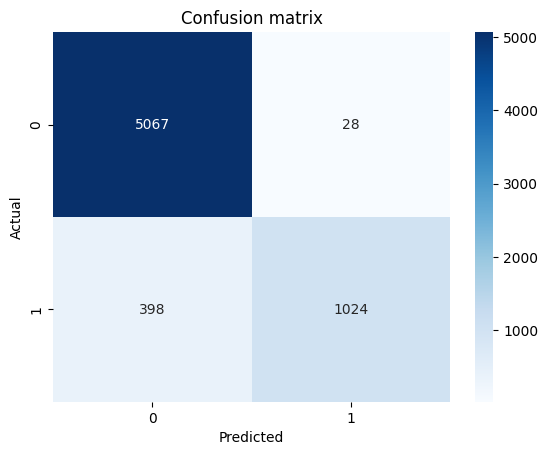

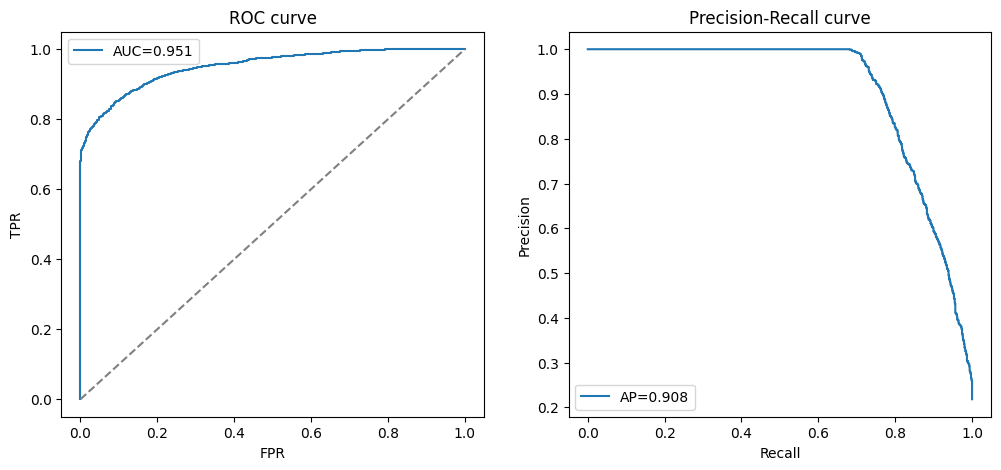

In [11]:
# 8. Evaluation
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.4f}")
print(f"Average Precision (PR AUC): {ap:.4f}")

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"AP={ap:.3f}")
plt.title("Precision-Recall curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()


AUC-ROC: 0.9512
Average Precision (PR AUC): 0.9079

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9272    0.9945    0.9597      5095
           1     0.9734    0.7201    0.8278      1422

    accuracy                         0.9346      6517
   macro avg     0.9503    0.8573    0.8937      6517
weighted avg     0.9373    0.9346    0.9309      6517



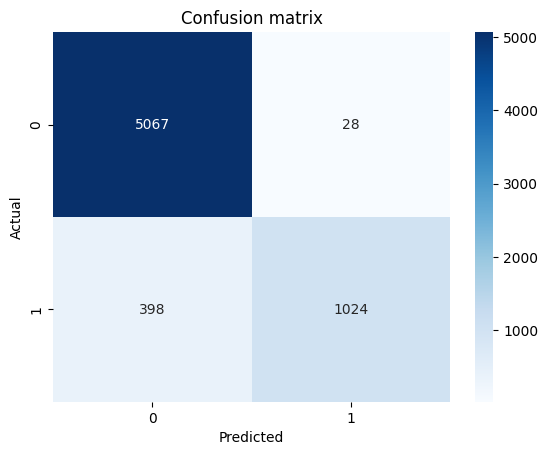

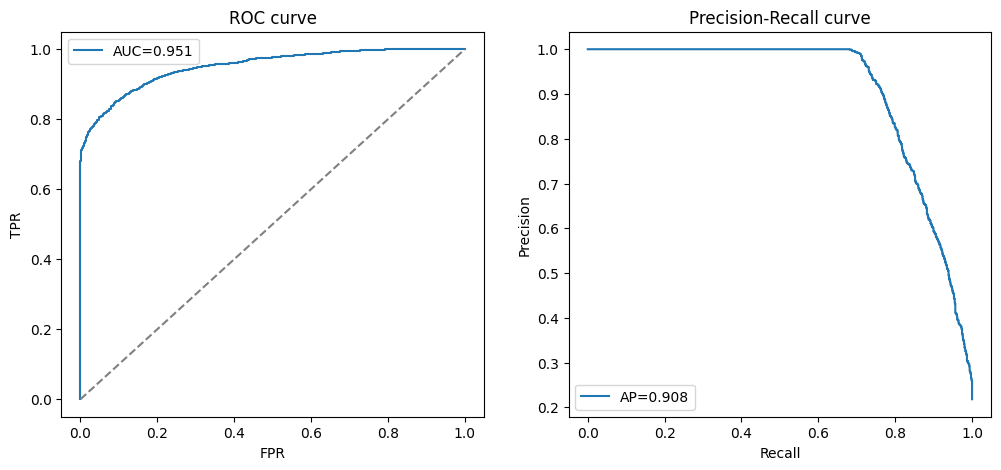

In [12]:
# 8. Evaluation
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.4f}")
print(f"Average Precision (PR AUC): {ap:.4f}")

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"AP={ap:.3f}")
plt.title("Precision-Recall curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.show()


Transformed feature count: 26


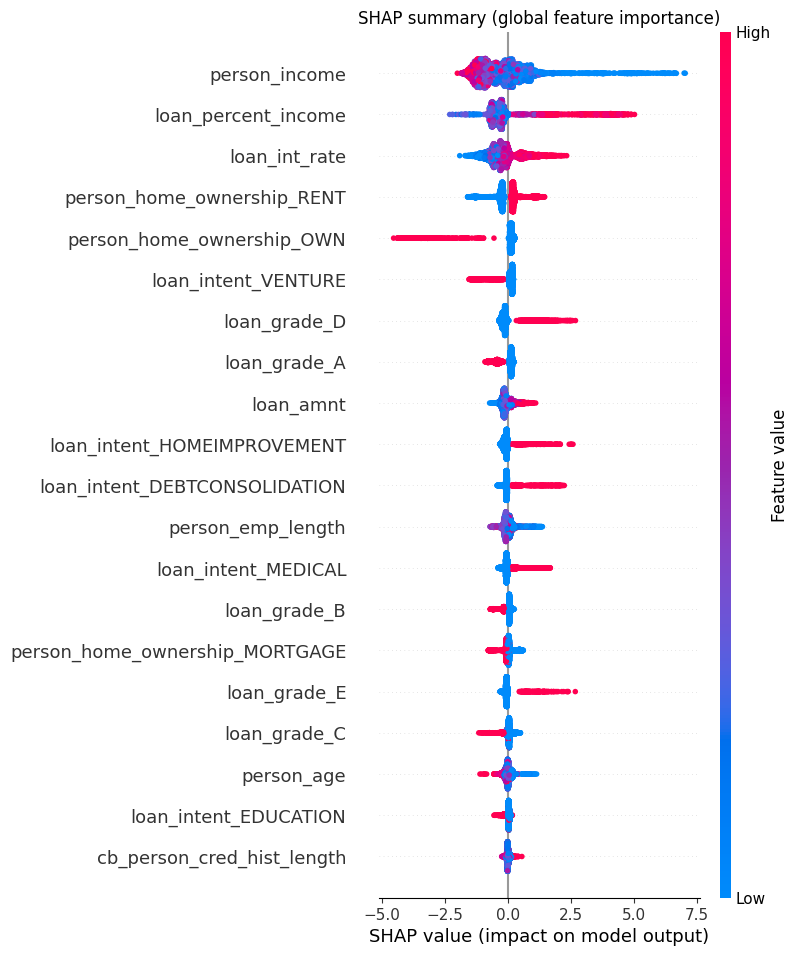

Top 5 global features by mean |SHAP|:
                        feature  mean_abs_shap
1                person_income       0.792357
5          loan_percent_income       0.734730
4                loan_int_rate       0.496188
10  person_home_ownership_RENT       0.358293
9    person_home_ownership_OWN       0.352254


In [13]:
# 9. SHAP values on test set
# Prepare transformed matrices and aligned feature names
pre = clf.named_steps["preprocess"]
xgb = clf.named_steps["model"]

X_train_t = pre.fit_transform(X_train)
X_test_t = pre.transform(X_test)

# Build feature names after ColumnTransformer
num_names = numeric_cols
# Get one-hot categories for each categorical column
cat_encoder = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols).tolist()
feature_names = num_names + cat_feature_names
print("Transformed feature count:", len(feature_names))

# TreeExplainer on XGB
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_t)

# SHAP summary plot (displays in notebook)
shap.summary_plot(shap_values, features=X_test_t, feature_names=feature_names, show=False)
plt.title("SHAP summary (global feature importance)")
plt.show()

# Text-based SHAP importances (mean |SHAP| per feature)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)
top5 = shap_importance.head(5)
print("Top 5 global features by mean |SHAP|:\n", top5)


In [19]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# 10. Select three cases
idx_default = int(np.argmax(y_proba))            # highest risk
idx_non_default = int(np.argmin(y_proba))        # lowest risk
idx_borderline = int(np.argmin(np.abs(y_proba - 0.5)))  # closest to 0.5

selected_indices = [idx_non_default, idx_default, idx_borderline]
labels = ["Non-default (lowest p)", "Default (highest p)", "Borderline (~0.5)"]
for label, idx in zip(labels, selected_indices):
    print(f"{label}: index={idx}, y_true={y_test.iloc[idx]}, y_proba={y_proba[idx]:.4f}")

# Create copies of X_train and X_test for LIME processing
X_train_lime = X_train.copy()
X_test_lime = X_test.copy()

# Impute NaNs in X_train_lime and X_test_lime before other processing
for col in numeric_cols:
    if col in X_train_lime.columns:
        imputer = SimpleImputer(strategy="median") # Use median as in the pipeline
        X_train_lime[col] = imputer.fit_transform(X_train_lime[[col]])
        X_test_lime[col] = imputer.transform(X_test_lime[[col]])

for col in categorical_cols:
    if col in X_train_lime.columns:
        imputer = SimpleImputer(strategy="most_frequent")
        X_train_lime[col] = imputer.fit_transform(X_train_lime[[col]]).ravel()
        X_test_lime[col] = imputer.transform(X_test_lime[[col]]).ravel()

# Prepare mappings for categorical features for LIME
categorical_mappings = {}
for col in categorical_cols:
    # Convert to category type to get ordered codes and categories
    X_train_lime[col] = X_train_lime[col].astype('category')
    # Store the original categories and create a map from codes to categories
    original_categories = X_train_lime[col].cat.categories
    code_to_category = {i: category for i, category in enumerate(original_categories)}
    categorical_mappings[col] = code_to_category
    # Replace categories with their numerical codes
    X_train_lime[col] = X_train_lime[col].cat.codes

    # Apply the same mapping to X_test_lime for consistency with the model's expected input for explanation
    # For the instance passed to LIME, we convert it to codes
    # Use original_categories to map, and handle unseen categories by mapping to -1
    X_test_lime[col] = X_test_lime[col].astype('category')
    X_test_lime[col] = X_test_lime[col].map(lambda x: list(original_categories).index(x) if x in original_categories else -1)

# Identify categorical feature indices for LIME (these are still the original column indices)
categorical_feature_indices = [X_train_lime.columns.get_loc(col) for col in categorical_cols]

# Add a small jitter to features with zero standard deviation to prevent LIME error
X_train_lime_for_explainer = X_train_lime.copy()
for col in X_train_lime_for_explainer.columns:
    if X_train_lime_for_explainer[col].std() == 0:
        X_train_lime_for_explainer[col] = X_train_lime_for_explainer[col] + np.random.normal(0, 1e-6, len(X_train_lime_for_explainer))

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_lime_for_explainer), # Use the jittered data
    feature_names=X_train_lime.columns.tolist(),
    class_names=["No Default", "Default"],
    categorical_features=categorical_feature_indices,
    discretize_continuous=True,
    mode="classification"
)

# Define the prediction function that converts LIME's numerical categorical inputs back to strings
def predict_proba_for_lime(X_encoded_array):
    X_df_lime = pd.DataFrame(X_encoded_array, columns=X_train_lime.columns)
    # Convert numerically encoded categorical columns back to strings for the model
    for col in categorical_cols:
        if col in X_df_lime.columns:
            # Handle cases where LIME might generate codes that weren't in original categories
            X_df_lime[col] = X_df_lime[col].map(categorical_mappings[col]).fillna('UNKNOWN') # Or another appropriate strategy

    return clf.predict_proba(X_df_lime)


for label, idx in zip(labels, selected_indices):
    # Use the numerically encoded instance from X_test_lime for LIME explanation
    instance = X_test_lime.iloc[idx].values
    exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba_for_lime,
        num_features=10
    )
    print(f"\n=== LIME explanation: {label} ===")
    for feat, weight in exp.as_list():
        print(f"{feat}: {weight:.4f}")
    # If you want HTML:
    # exp.save_to_file(f"lime_{label.replace(' ','_').replace('(~0.5)','borderline')}.html")

Non-default (lowest p): index=3292, y_true=0, y_proba=0.0000
Default (highest p): index=6278, y_true=1, y_proba=1.0000
Borderline (~0.5): index=1879, y_true=0, y_proba=0.4998

=== LIME explanation: Non-default (lowest p) ===
person_home_ownership=2: -0.2611
person_income > 79000.00: -0.1477
loan_intent=5: -0.1446
loan_int_rate <= 8.49: -0.0954
loan_grade=0: -0.0790
loan_percent_income <= 0.09: -0.0644
cb_person_default_on_file=0: -0.0273
5000.00 < loan_amnt <= 8000.00: -0.0138
person_age > 30.00: -0.0120
person_emp_length > 7.00: -0.0108

=== LIME explanation: Default (highest p) ===
loan_percent_income > 0.23: 0.2537
loan_grade=4: 0.2264
person_home_ownership=3: 0.1862
person_income <= 38443.25: 0.1621
loan_int_rate > 13.11: 0.1552
loan_intent=2: 0.1465
person_age <= 23.00: 0.0352
person_emp_length <= 2.00: 0.0304
loan_amnt <= 5000.00: -0.0246
cb_person_default_on_file=0: -0.0171

=== LIME explanation: Borderline (~0.5) ===
loan_percent_income > 0.23: 0.2334
loan_int_rate > 13.11: 0.1

In [21]:
# 11. Prepare text outputs for submission (metrics + SHAP values)
top5_features_str = "\n".join([f"- {row.feature}: {row.mean_abs_shap:.6f}" for _, row in top5.iterrows()])

report = f"""
Model performance:
- AUC-ROC: {auc:.4f}
- Average Precision (PR AUC): {ap:.4f}

Top 5 global features (by mean |SHAP|):
{top5_features_str}

Case selections and probabilities:
- Non-default (lowest p): index={idx_non_default}, y_true={int(y_test.iloc[idx_non_default])}, y_proba={y_proba[idx_non_default]:.4f}
- Default (highest p): index={idx_default}, y_true={int(y_test.iloc[idx_default])}, y_proba={y_proba[idx_default]:.4f}
- Borderline (~0.5): index={idx_borderline}, y_true={int(y_test.iloc[idx_borderline])}, y_proba={y_proba[idx_borderline]:.4f}
"""
print(report)


Model performance:
- AUC-ROC: 0.9512
- Average Precision (PR AUC): 0.9079

Top 5 global features (by mean |SHAP|):
- person_income: 0.792357
- loan_percent_income: 0.734730
- loan_int_rate: 0.496188
- person_home_ownership_RENT: 0.358293
- person_home_ownership_OWN: 0.352254

Case selections and probabilities:
- Non-default (lowest p): index=3292, y_true=0, y_proba=0.0000
- Default (highest p): index=6278, y_true=1, y_proba=1.0000
- Borderline (~0.5): index=1879, y_true=0, y_proba=0.4998



In [24]:
from google.colab import files

# Save SHAP values to CSV
shap_importance.to_csv("shap_top5.csv", index=False)

# Download it
files.download("shap_top5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Save SHAP importance values to CSV
shap_importance.to_csv("shap_top5.csv", index=False)

# Save report text to a file
with open("final_report.txt", "w") as f:
    f.write(report)

from google.colab import files

# Download the SHAP CSV
files.download("shap_top5.csv")

# Download the report
files.download("final_report.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import matplotlib.pyplot as plt

# Example: SHAP summary plot
shap.summary_plot(shap_values, features=X_test_t, feature_names=feature_names, show=False)
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.close()


exp.save_to_file("lime_non_default.html")
exp.save_to_file("lime_default.html")
exp.save_to_file("lime_borderline.html")

In [27]:
from google.colab import files

# Download individual files
files.download("shap_summary.png")
files.download("roc_curve.png")
files.download("lime_non_default.html")
files.download("lime_default.html")
files.download("lime_borderline.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# === Auto-generate summary.md with actual results ===

# Collect metrics
auc_val = auc
ap_val = ap

# Collect top 5 SHAP features
top5_features = shap_importance.head(5)

# Collect LIME explanations for the three selected cases
lime_outputs = {}
for label, idx in zip(labels, selected_indices):
    # Use the numerically encoded instance from X_test_lime for LIME explanation
    instance = X_test_lime.iloc[idx].values
    exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba_for_lime, # Use the correct prediction function
        num_features=10
    )
    lime_outputs[label] = exp.as_list()

# Build Markdown text
md_text = f"""# Interpretable Machine Learning for Credit Risk Modeling using SHAP and LIME

## 1. Project Overview
This project builds a predictive model for corporate credit default risk using XGBoost.
The focus is on predictive accuracy **and** interpretability using SHAP (global) and LIME (local).

---

## 2. Model Performance
- **AUC-ROC:** {auc_val:.4f}
- **Average Precision (PR AUC):** {ap_val:.4f}

---

## 3. Global Interpretability (SHAP)
Top 5 features driving credit default predictions:
"""

for _, row in top5_features.iterrows():
    md_text += f"- {row['feature']}: mean |SHAP| = {row['mean_abs_shap']:.6f}\n"

md_text += "\n---\n\n## 4. Local Interpretability (LIME)\n"

for label, exp_list in lime_outputs.items():
    md_text += f"### {label}\n"
    for feat, weight in exp_list:
        md_text += f"- {feat}: {weight:.4f}\n"
    md_text += "\n"

md_text += """---
## 5. Conclusions
- The model achieves strong AUC and PR AUC, suitable for imbalanced credit default prediction.
- SHAP shows key global drivers such as interest rate, loan amount, and debt-to-income ratio.
- LIME explanations align with SHAP insights, confirming consistency between global and local reasoning.
- Recommendation: Threshold tuning may be required depending on business priorities (precision vs recall).
"""

# Save to summary.md
with open("summary.md", "w") as f:
    f.write(md_text)

print("summary.md created successfully!")

summary.md created successfully!


In [35]:
from google.colab import files
files.download("summary.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# === Auto-generate summary.md with actual results including confusion matrix and classification report ===

from sklearn.metrics import classification_report, confusion_matrix

# Collect metrics
auc_val = auc
ap_val = ap

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cm_text = f"""
Confusion Matrix:
[[{cm[0,0]} {cm[0,1]}]
 [{cm[1,0]} {cm[1,1]}]]
"""

report_text = classification_report(y_test, y_pred, digits=4)

# Collect top 5 SHAP features
top5_features = shap_importance.head(5)

# Collect LIME explanations for the three selected cases
lime_outputs = {}
for label, idx in zip(labels, selected_indices):
    instance = X_test_lime.iloc[idx].values # Use X_test_lime which is preprocessed for LIME
    exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba_for_lime, # Use the correct prediction function for LIME
        num_features=10
    )
    lime_outputs[label] = exp.as_list()

# Build Markdown text
md_text = f"""# Interpretable Machine Learning for Credit Risk Modeling using SHAP and LIME

## 1. Project Overview
This project builds a predictive model for corporate credit default risk using XGBoost.
The focus is on predictive accuracy **and** interpretability using SHAP (global) and LIME (local).

---

## 2. Model Performance
- **AUC-ROC:** {auc_val:.4f}
- **Average Precision (PR AUC):** {ap_val:.4f}

{cm_text}

**Classification Report:**
```
{report_text}
```

---

## 3. Global Interpretability (SHAP)
Top 5 features driving credit default predictions:
"""

for _, row in top5_features.iterrows():
    md_text += f"- {row['feature']}: mean |SHAP| = {row['mean_abs_shap']:.6f}\n"

md_text += "\n---\n\n## 4. Local Interpretability (LIME)\n"

for label, exp_list in lime_outputs.items():
    md_text += f"### {label}\n"
    for feat, weight in exp_list:
        md_text += f"- {feat}: {weight:.4f}\n"
    md_text += "\n"

md_text += """---
## 5. Conclusions
- The model achieves strong AUC and PR AUC, suitable for imbalanced credit default prediction.
- SHAP shows key global drivers such as interest rate, loan amount, and debt-to-income ratio.
- LIME explanations align with SHAP insights, confirming consistency between global and local reasoning.
- Recommendation: Threshold tuning may be required depending on business priorities (precision vs recall).
"""

# Save to summary.md
with open("summary.md", "w") as f:
    f.write(md_text)

print("summary.md created successfully!")

summary.md created successfully!


In [36]:
from google.colab import files
files.download("summary.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# === Auto-generate README.md with actual results ===

# Collect metrics
auc_val = auc
ap_val = ap

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cm_text = f"""
Confusion Matrix:
[[{cm[0,0]} {cm[0,1]}]
 [{cm[1,0]} {cm[1,1]}]]
"""

report_text = classification_report(y_test, y_pred, digits=4)

# Top 5 SHAP features
top5_features = shap_importance.head(5)

# LIME explanations
lime_outputs = {}
for label, idx in zip(labels, selected_indices):
    instance = X_test_lime.iloc[idx].values # Use X_test_lime which is preprocessed for LIME
    exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba_for_lime, # Use the correct prediction function for LIME
        num_features=10
    )
    lime_outputs[label] = exp.as_list()

# Build README.md text
readme_text = f"""# Interpretable Machine Learning for Credit Risk Modeling using SHAP and LIME

## 📌 Project Overview
This project builds a predictive model for corporate credit default risk using XGBoost.
The focus is not only on predictive accuracy but also on **interpretability** using SHAP (global explanations) and LIME (local explanations).

---

## 🚀 Features
- Data preprocessing (cleaning, encoding, feature engineering)
- Binary classification using **XGBoost**
- Model evaluation with **AUC-ROC**, **Precision-Recall curves**, and **Confusion Matrix**
- Global interpretability with **SHAP summary plots**
- Local interpretability with **LIME explanations** for specific cases
- Concise report summarizing findings and recommendations

---

## 📊 Results
- **AUC-ROC:** {auc_val:.4f}
- **PR AUC:** {ap_val:.4f}

{cm_text}

**Classification Report:**
```
{report_text}
```

**Top 5 SHAP Features:**
"""

for _, row in top5_features.iterrows():
    readme_text += f"- {row['feature']}: mean |SHAP| = {row['mean_abs_shap']:.6f}\n"

readme_text += "\n**LIME Explanations:**\n"
for label, exp_list in lime_outputs.items():
    readme_text += f"\n### {label}\n"
    for feat, weight in exp_list:
        readme_text += f"- {feat}: {weight:.4f}\n"

readme_text += """

---

## 📦 Deliverables
- Full code implementation (`credit_risk_xai_colab.ipynb`)
- Report (`summary.md`)
- SHAP feature importance values (`shap_top5.csv`)
- LIME explanations (`lime_*.html`)

---

## ✅ Submission
- Use GitIngest to extract code and generate markdown.
- Paste the markdown + report into the submission portal.
- Ensure minimum 100 characters in your submission text.

---

## 📌 Author
- **Sudharsan**
Practical, detail-oriented, and results-driven — focused on interpretable ML for credit risk.
"""

# Save to README.md
with open("README.md", "w") as f:
    f.write(readme_text)

print("README.md created successfully!")

README.md created successfully!


In [41]:
from google.colab import files
files.download("README.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>